In [1]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
# Picture visualization.  
def show_img(a=0, **images):
    plt.figure(figsize=(15,5))
    for idx, (name, image) in enumerate(images.items()): 
        title_pict = list(images.keys())[0]
        img = images[title_pict]
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([]); plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=12)
        plt.imshow(image)
        plt.imshow(img, alpha=a)
    plt.show()

### Step 1
Loading a pre-trained torchvision.models.detection network.keypointrcnn_resnet50_fpn.  
  
Preparing her for the inference.

In [3]:
# Loading and preparing the pre-trained keypointrcnn_resnet50_fpn model. 
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights='DEFAULT')

# Preparing the model for the inference. 
model.eval();

### Step 2
Creating a list of frame reference points.

In [4]:
keypoints = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle'
    ]

### Step 3
Apply the `transforms' transformation.Compose([T.ToTensor()])` to the image of a running girl. There is no augmentation, the usual translation of the array into the PyTorch tensor.

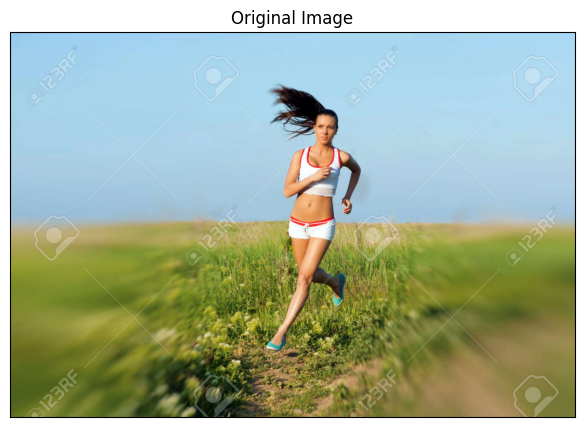

In [5]:
# The path to the image. 
path_model ="../images/running_girl_ref.png"

# Uploading an image and converting it to RGB format.  
img_model = cv2.imread(path_model)

# Image transformation.  
transform = transforms.Compose([transforms.ToTensor()])
tensor_model = transform(img_model)

# Image output.  
show_img(
    Original_image = img_model[:,:,::-1]
    )

### Step 4
Run the image through the model to get a list with a dictionary of labels.  

In [6]:
with torch.no_grad():
    output_model = model([tensor_model])

output_model

[{'boxes': tensor([[596.8143, 172.3236, 807.4850, 741.4597],
          [496.9932, 396.7905, 525.2551, 434.5749]]),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9998, 0.0771]),
  'keypoints': tensor([[[724.2095, 230.4552,   1.0000],
           [736.3423, 221.5970,   1.0000],
           [716.4885, 217.1680,   1.0000],
           [750.6812, 226.0261,   1.0000],
           [702.1497, 222.7043,   1.0000],
           [762.8140, 288.0332,   1.0000],
           [667.9570, 284.7113,   1.0000],
           [795.9037, 319.0367,   1.0000],
           [640.3823, 364.4347,   1.0000],
           [778.2559, 379.9365,   1.0000],
           [702.1497, 336.7530,   1.0000],
           [719.7975, 447.4799,   1.0000],
           [661.3391, 446.3726,   1.0000],
           [675.6779, 564.8503,   1.0000],
           [686.7078, 560.4213,   1.0000],
           [626.0435, 689.9717,   1.0000],
           [747.3722, 577.0303,   1.0000]],
  
          [[516.0156, 404.8871,   1.0000],
           [518.1896, 403.80

### Step 5
Drawing key points using the function `draw_keypoints_per_person`.

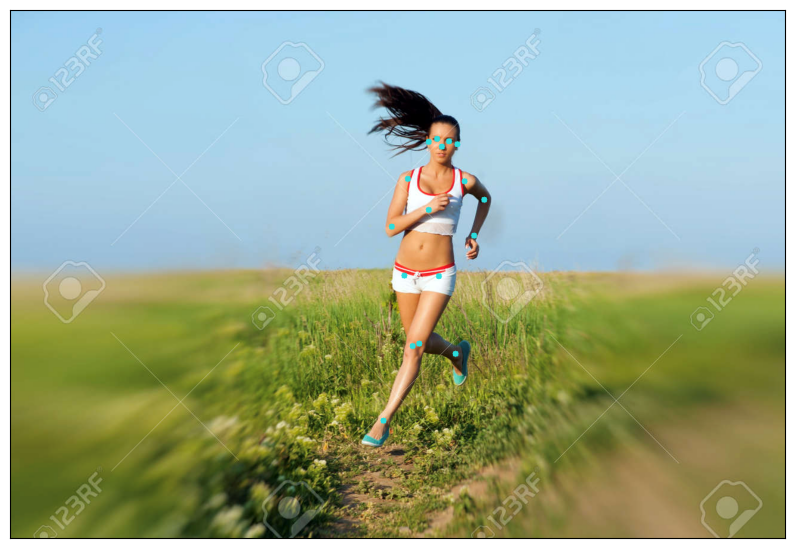

In [7]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, 
    keypoint_threshold=2, conf_threshold=0.9
):
    cmap = plt.get_cmap("rainbow")
    img_copy = img.copy()
    color_id = (np.linspace(0, 255, len(all_keypoints)+2).astype(int).tolist()[1:-1])

    for person_id in range(len(all_keypoints)):
        if confs[person_id] > conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
            for kp in range(len(scores)):
                if scores[kp] > keypoint_threshold:
                    keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

keypoints_img = draw_keypoints_per_person(
    img_model[:,:,::-1], 
    output_model[0]["keypoints"], 
    output_model[0]["keypoints_scores"], 
    output_model[0]["scores"]
    )

fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(keypoints_img)
plt.xticks([]); plt.yticks([])
plt.show();

### Step 6
Creating "limbs" using an auxiliary function.

In [8]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), 
        keypoints.index("nose")],
        [keypoints.index("right_eye"), 
        keypoints.index("right_ear")],
        [keypoints.index("left_eye"), 
        keypoints.index("nose")],
        [keypoints.index("left_eye"), 
        keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), 
        keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), 
        keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), 
        keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), 
        keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), 
        keypoints.index("right_knee")],
        [keypoints.index("right_knee"), 
        keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), 
        keypoints.index("left_knee")],
        [keypoints.index("left_knee"), 
        keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), 
        keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), 
        keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), 
        keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), 
        keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints)

### Step 7
The function of rendering the frame (skeleton) based on the already existing function of rendering key points.

In [9]:
def draw_skeleton_per_person(
            img, all_keypoints, all_scores, confs, 
            keypoint_threshold=2, conf_threshold=0.9):    

    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    color_id = (np.linspace(0, 255, len(all_keypoints)+2).astype(int).tolist()[1:-1])

    if len(all_keypoints)>0:
      
      for person_id in range(len(all_keypoints)):
          if confs[person_id]>conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]

            color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
            
            for kp in range(len(scores)):
                if scores[kp] > keypoint_threshold:
                    keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                    cv2.circle(img_copy, keypoint, 5, color, -1)
            
            for limb_id in range(len(limbs)):
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)

              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              if limb_score> keypoint_threshold:
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 2)

    return img_copy

skeletal_img = draw_skeleton_per_person(
    img_model[:,:,::-1], 
    output_model[0]["keypoints"], 
    output_model[0]["keypoints_scores"], 
    output_model[0]["scores"]
    )     

<font color='white'>

### Step 8</font>
Rendering the frame on the image.

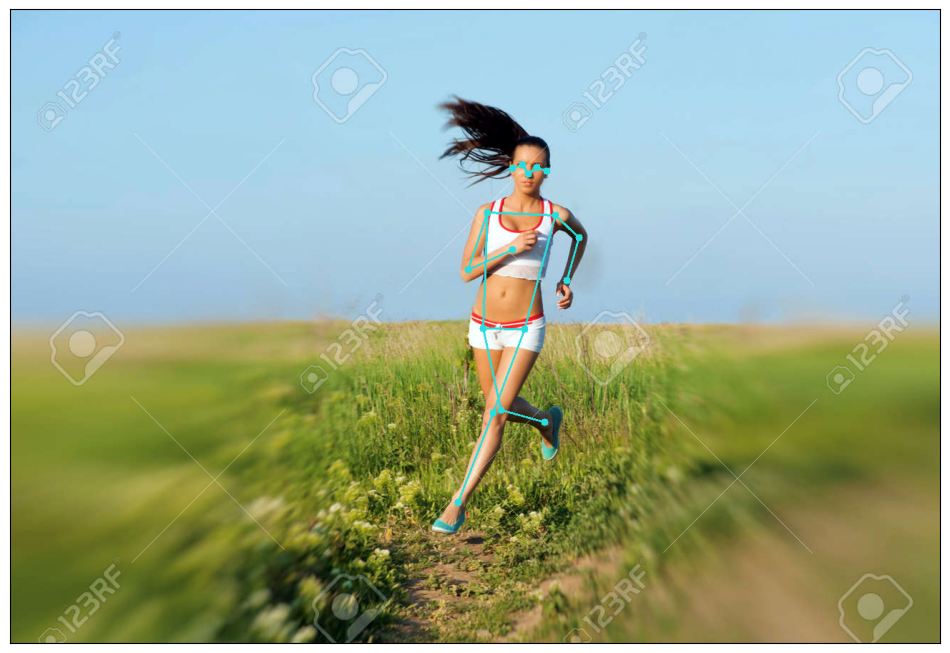

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(skeletal_img)
plt.xticks([]); plt.yticks([]) 
plt.show();  